In [46]:
import torch
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.utils.data import DataLoader 
import numpy as np 
import matplotlib.pyplot as plt 
import data
import gpt 
from tqdm import tqdm, trange
import json 
import matplotlib

device = 'cpu' #'cuda' if torch.cuda.is_available() else 'cpu' 
if device == 'cuda':
  print(torch.cuda.get_device_name()) 
else: 
  print(device) 

with open('config.json', 'r') as file: 
  config = json.load(file)

lr = config['lr']
bs = config['batch_size']

vocab_size, encode = data._init_data() 

cpu


In [2]:
model = gpt.gpt_model(vocab_size=vocab_size).to(device) 
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters.')
model.load_state_dict(torch.load('/media/uzal/New Volume/hyperion_models/adaptive_span_models/adaptive_span_final_23k.pth'))

59.968665 M parameters.


<All keys matched successfully>

In [10]:
print(data.decode(data.dataloader(split='test')[0][0].tolist()))

! And nothing with padlocks on it! .
Rachel Green: Ross, look, I know that some of this stuff is out there, but I mean, come on, look at this, look at this sweater! . I mean, this is just beautiful!
Ross Geller: Wow, this is really soft . Three hundred and fifty dollars?
Rachel Green: Yeah, down from seven hundred, you are saving like two hundred bucks!
Ross Geller: Both logic and math are taking a serious hit today. Phoebe : Hey, check this out! It's totally you!
Ross Geller: Wow!
Phoebe Buffay: Yeah!
Ross Geller: Actually this looks like pretty good! Yeah! Boys will be boys?
Phoebe Buffay: What? They will be!
Ross Geller: All right, that's it, I'm getting out of here.
Rachel Green: No, no, no, no! Ross, wait! Come on! You know, there's other stuff. Here's a nice shirt, look at these nice pants...
Ross Geller: Uh, actually these might look pretty good on me.
Rachel Green: Yes, they will! You know what you should do? Just go take a walk, all right? I know your size and I'm... I'm gonna

In [70]:
n_heads = config['n_head']
n_blocks = config['n_layer']

In [71]:
def head(x): 
  all_weights = dict() 
  for block_idx in range(n_blocks): 
    for head_idx in range(n_heads): 
      k = model.blocks[block_idx].sa.heads[head_idx].key(x) 
      q = model.blocks[block_idx].sa.heads[head_idx].query(x) 
      weight = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5
      weight = weight.masked_fill(model.blocks[block_idx].sa.heads[head_idx].tril[:x.size(1), :x.size(1)] == 0, float('-inf'))
      weight = F.softmax(weight, dim=-1)
      weight2 = model.blocks[block_idx].sa.heads[head_idx].adaptive_span(weight)
      all_weights[f'{block_idx}_{head_idx}'] = weight2
  
  return all_weights

In [72]:
# basically here, we are retracing the forward pass and investigating only the first 
# adaptive span outputs that ultimately multiply with the 'value' and change the 
# output of the self-attention in meaningful ways. 
test_in = (data.dataloader(split='test')[0][0]).unsqueeze(0).to(device)

with torch.no_grad(): 
	# get the token embeddings and the positional embeddings 
	tok_emb = model.token_embedding(test_in)
	pos_emb = model.position_embedding(torch.arange(test_in.size(1), device=device))
	x = tok_emb + pos_emb 
	x = model.blocks[0].ln1(x) 
	# get all the 'weights' that are calculated by the 'keys' and 'values' 
	all_weights = head(x)

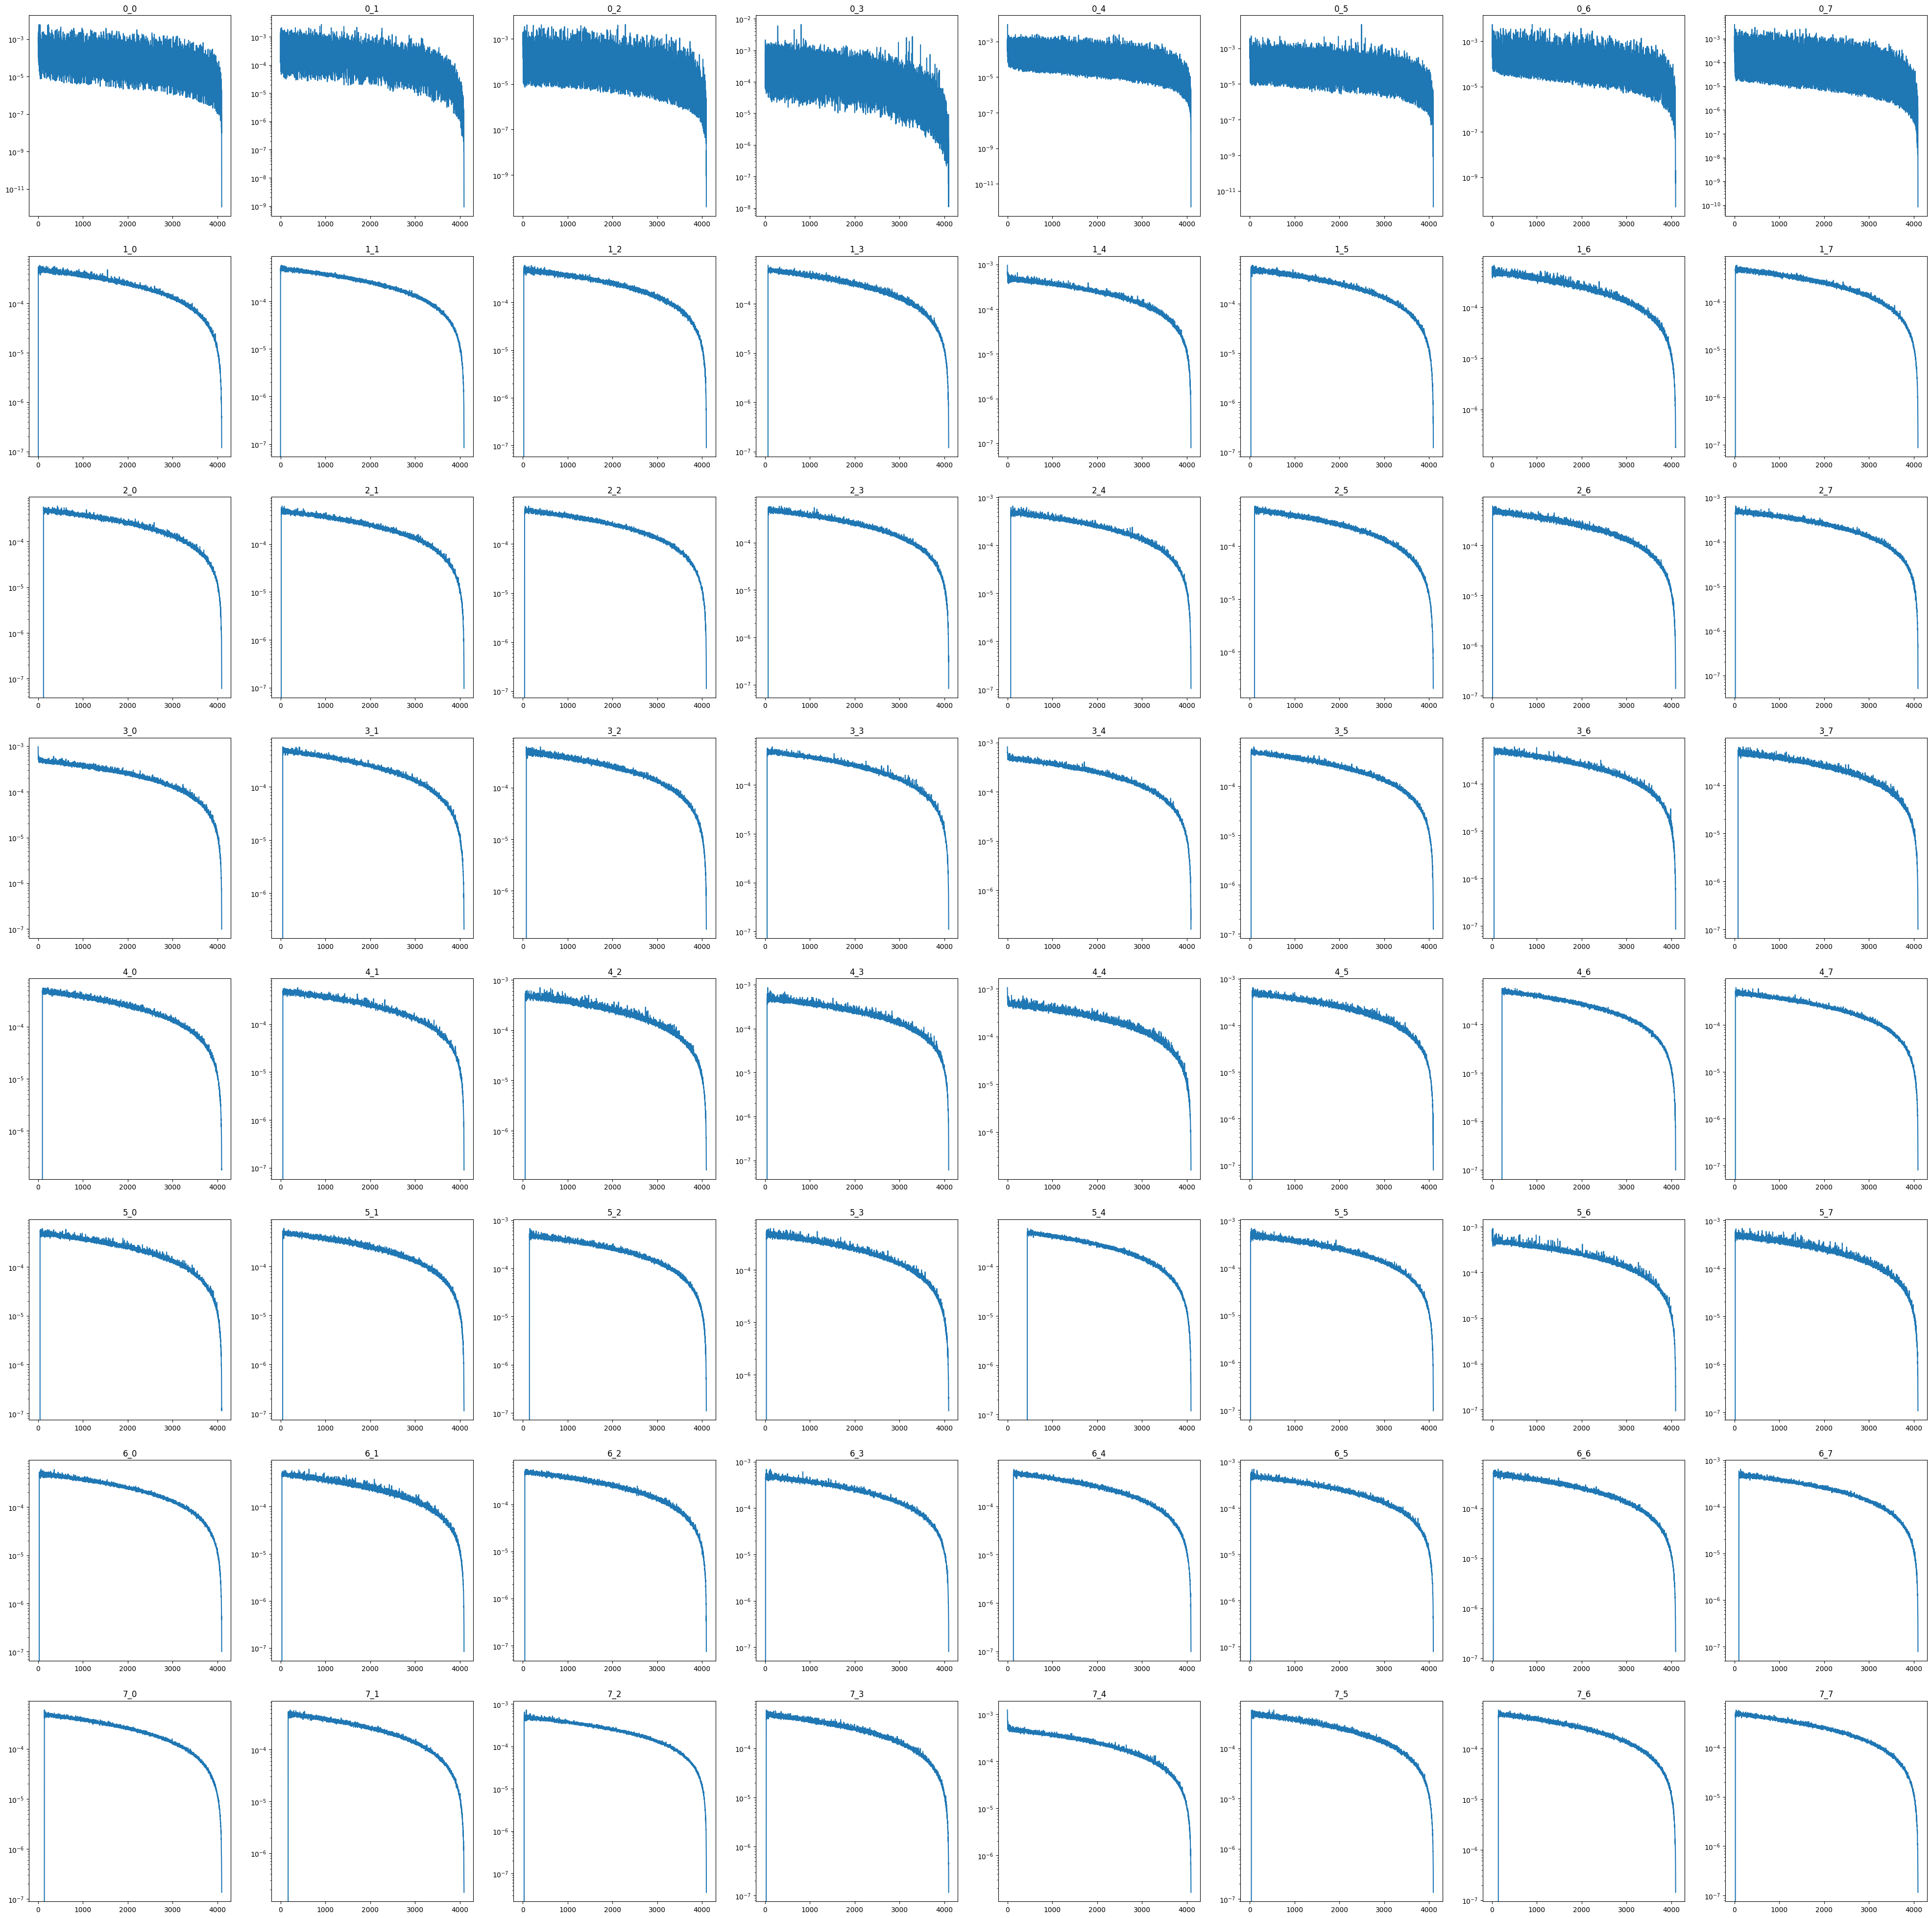

In [102]:
fig, axis = plt.subplots(8, 8)
fig.set_size_inches(50, 50)
for n, i in list(all_weights.items()): 
  axis[int(n[0]), int(n[-1])].plot(i[0].mean(0))
  axis[int(n[0]), int(n[-1])].set_yscale('log')
  axis[int(n[0]), int(n[-1])].set_title(n)